# Stock Market Forecasting Using Long Short Term Memory (LSTM)
This notebook uses LSTM networks to predict stock prices. By leveraging historical data, LSTMs can capture patterns in time-series data to make future price predictions. Key steps include data collection, preprocessing, model training, and forecasting future trends.

## Import Libraries
This section imports the necessary libraries for data manipulation, model building, and visualization, including pandas, numpy, scikit-learn, TensorFlow...

In [108]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## Data

### Download

we define the stock symbol (TSLA) and set the start and end dates for the historical data. The end date is dynamically set to the current date to ensure up-to-date data retrieval.

In [109]:
# Define the stock symbol and the date range for our data
stock_symbol = 'TSLA'
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date
print(f"Ticker: {stock_symbol}\nStart Date: {start_date}\nEnd Date: {end_date}")

Ticker: TSLA
Start Date: 2000-01-01
End Date: 2024-12-04


In [110]:
df = yf.download(stock_symbol, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


In this section, we organize the DataFrame by selecting relevant columns ('Open', 'Close', 'Volume', 'Low', 'High') and ensuring the date is set as the index. The index is reset and renamed to "Date" to facilitate further analysis, and the 'Date' column is converted to a datetime type for consistency.

In [111]:
# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Open', 'Close', 'Volume', 'Low', 'High']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)

df.head()

Price,Open,Close,Volume,Low,High
Date,,,,,
2010-06-29,1.266667,1.592667,281494500,1.169333,1.666667
2010-06-30,1.719333,1.588667,257806500,1.553333,2.028000
2010-07-01,1.666667,1.464000,123282000,1.351333,1.728000
2010-07-02,1.533333,1.280000,77097000,1.247333,1.540000
2010-07-06,1.333333,1.074000,103003500,1.055333,1.333333


### Visualize Stock Data

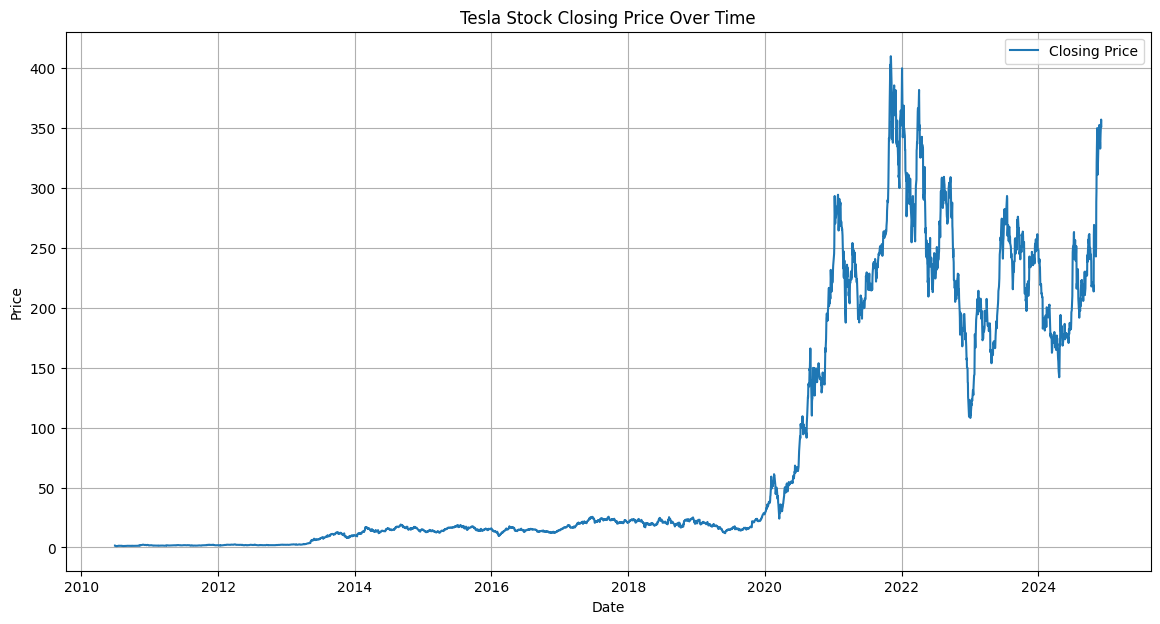

In [112]:
# Plot the closing price over time
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Closing Price')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Preprocess Data

### Scale Data
In this step, we extract the `Close` prices for forecasting and reshape the data to a 2D array. The `MinMaxScaler` is then used to normalize the data, scaling it to a range between 0 and 1 to prepare it for training the model.

In [113]:
# Use the 'Close' prices for forecasting
data = df['Close'].values

# Reshape the data to 2D array (required for MinMaxScaler)
data = data.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

### Split Data
The dataset is split into `training (80%)` and `testing (20%)` sets. A function is defined to prepare the data for the LSTM model by creating sequences of 30 previous days' prices to predict the next day's price. The data is then reshaped into 3D arrays to match the LSTM input format.

In [114]:
# Split the data into training and test sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create a function to prepare the data for LSTM
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare training and testing data
time_step = 30  # Using 30 previous days to predict the next one
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the data into 3D array for LSTM input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train.shape, X_test.shape

((2875, 30, 1), (696, 30, 1))

## LSTM Model Training

### Build the LSTM Model
An LSTM model is built with two LSTM layers, each having 50 units. The first layer returns sequences to feed into the second layer, while the output layer uses the `ReLU` activation function to ensure non-negative predictions. The model is compiled using the `Adam optimizer` and `mean squared error` loss. The model summary is displayed to show the architecture.

In [115]:
# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))

# Output layer with ReLU activation to ensure non-negative predictions
model.add(Dense(units=1, activation='relu'))  # ReLU prevents negative predictions

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model.summary()


c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\tutorials\technical_analysis\LSTM_stock_forecasting\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### Train
The model is trained using the training data for `50 epochs` with a `batch size of 32`. Validation data (test set) is provided to monitor performance during training and prevent overfitting.

In [116]:
# Train the LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model to a file
model.save(f'{stock_symbol}_lstm_stock_model.h5')

print("Model saved successfully!")

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0584e-04 - val_loss: 0.0028
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.9337e-04 - val_loss: 0.0020
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.2483e-04 - val_loss: 0.0022
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.0929e-04 - val_loss: 0.0023
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.6926e-04 - val_loss: 0.0015
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0183e-04 - val_loss: 0.0014
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.4235e-04 - val_loss: 0.0015
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1439e-04 - val_loss: 0.0010
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.1950e-04 - val_loss: 9.9779e-04
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.4824e-04 - val_loss: 9.6227e-04
Epoch 12/50
90/

Model saved successfully!


### Visualize Training Results

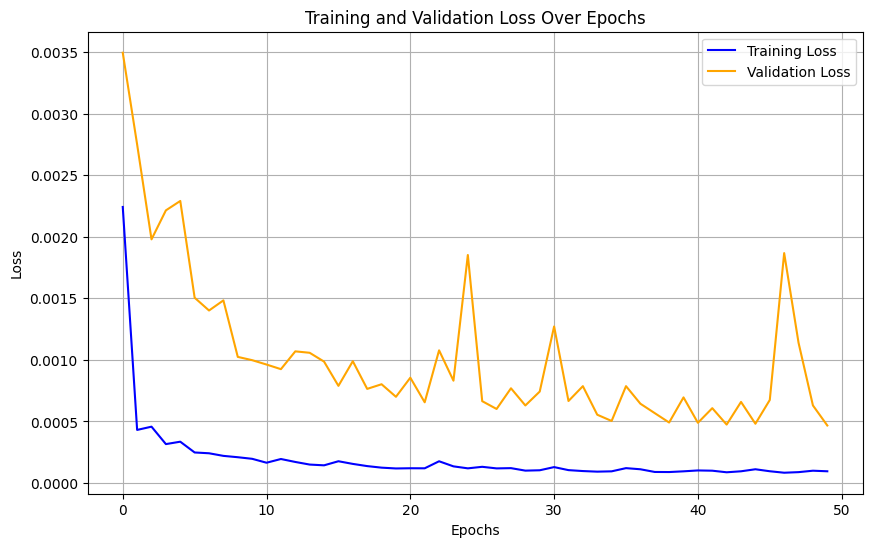

In [117]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

# Customize the plot
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Forecasting

### Predict Future Data
The model predicts stock prices on the test data, and both predicted and actual values are inverse-transformed to their original scale. Additionally, the model forecasts the next 30 days of stock prices using the most recent data, with each prediction used to update the input for subsequent forecasts.

In [118]:
# Predict on the test data
predicted_prices = model.predict(X_test)

# Inverse transform the predictions and actual values to get the original scale
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast
last_n_days = scaled_data[-time_step:].reshape(1, -1)
last_n_days = last_n_days.reshape((last_n_days.shape[0], last_n_days.shape[1], 1))

next_n = 30

predicted_next_n = []
for _ in range(next_n):
    next_day = model.predict(last_n_days)
    predicted_next_n.append(next_day[0, 0])
    last_n_days = np.append(last_n_days[:, 1:, :], next_day.reshape(1, 1, 1), axis=1)

predicted_next_n = scaler.inverse_transform(np.array(predicted_next_n).reshape(-1, 1))


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━

### Plot the prediction results

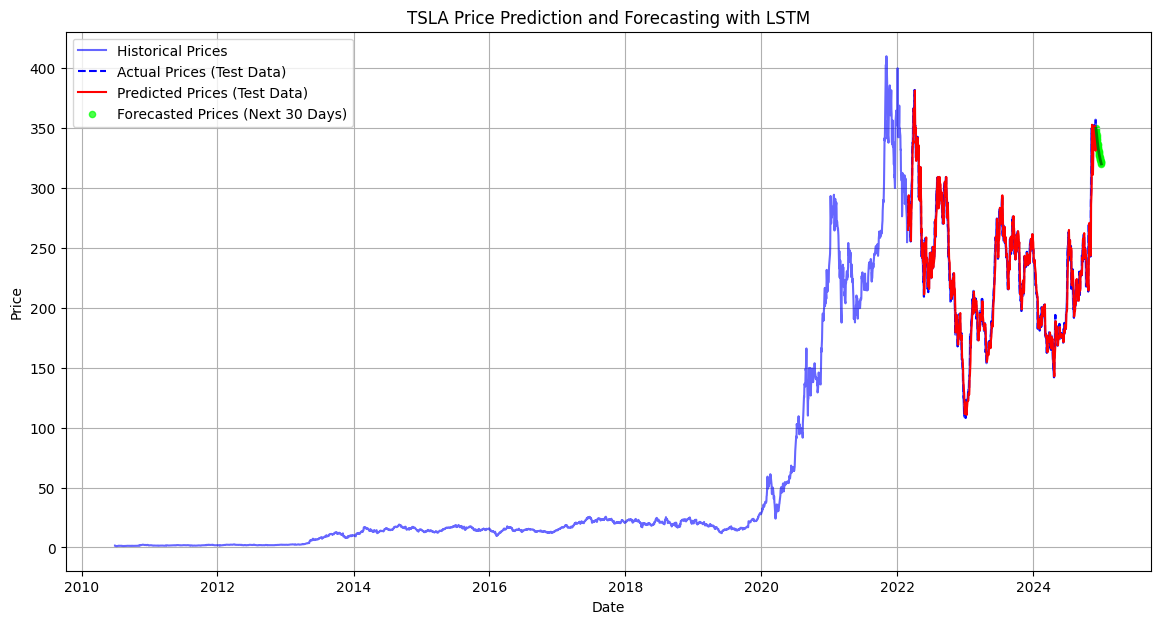

In [119]:
# Plot the historical data and forecasted target data
plt.figure(figsize=(14, 7))

# Plot the full historical closing prices
plt.plot(df.index, data, label='Historical Prices', color='blue', alpha=0.6)

# Plot the actual closing prices from test data (this part will be part of the full data)
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label='Actual Prices (Test Data)', color='blue', linestyle='--')

# Plot the predicted prices from the model (for test data)
plt.plot(df.index[-len(predicted_prices):], predicted_prices, label='Predicted Prices (Test Data)', color='red')

# Post-process the forecasted values to make sure they are non-negative
predicted_next_n[predicted_next_n < 0] = 0  # Prevent negative forecasted prices

# Plot the forecasted prices
forecast_dates = pd.date_range(df.index[-1], periods=next_n+1, freq='D')[1:]  # Generate dates for the forecast
plt.scatter(forecast_dates, predicted_next_n, label=f'Forecasted Prices (Next {next_n} Days)', color='lime', s=20, alpha=0.7)
plt.plot(forecast_dates, predicted_next_n, color='green', linestyle='-', linewidth=2)

# Customize the plot
plt.title(F'{stock_symbol} Price Prediction and Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()